# Transfer Learning with Tensorflow Part 1 : Feature Extraction

Transfer learning is leveraging a working model's exsisting architecture and learned patterns for our own problem,

There are two main benefits:
1. Can leverage an exsisting neural network architecture proven to work on problem similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similer data to our own , then we cam adapt those patterns to our own data

In [1]:
# Are we are using GPU?
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101) -https://www.kaggle.com/datasets/dansbecker/food-101
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-02-22 09:43:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.181.187, 192.178.24.219, 192.178.24.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.181.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  3.25MB/s    in 51s     

2024-02-22 09:43:54 (3.13 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# How many images in each folder
import os

# Walk through 10 percent data directory and list number of files
for dirpath , dirnames, filenames, in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath} .")

There are 2 directories and 0 images in 10_food_classes_10_percent .
There are 10 directories and 0 images in 10_food_classes_10_percent/train .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream

## Creating data loaders (preparing the data)

We will use the `ImageDateGenerator` class to load in our images in batches.


In [5]:
# Setup data input
from tensorflow.keras.preprocessing.image  import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images : ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")
print("Testing images : ")
test_data = test_datagen.flow_from_directory(test_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

Training images : 
Found 750 images belonging to 10 classes.
Testing images : 
Found 2500 images belonging to 10 classes.


## Setting up the callbacks (things to run whilst our model trains)

callbacks are extra functionality you can add to your models to be performed or after training . some of the most popular callbacks:
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training ( before it train too long and overfit ) with the EarlyStopping callback

In [6]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback (dir_name , experiment_name):
  log_dir = dir_name + "/"+ experiment_name +"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print (f"Saving TensorBoard log files to {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we have used TensorFlow to create our own models layers by layers from scratch .

Now we are going to do a similar process , except the majority of our models layers are going to come TensorFlow Hub.

We can access pretrained model on [TFHub.dev](https://tfhub.dev/)

Browsing the TensorFlow Hub page and sorting for image classcification we found the following features vector model link:

https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


In [7]:
# Lets compare the following two model

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [1]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
# Lets make a create_model () function to create a model from a URL
def create_model (model_url , num_classes = 10):
  """
  Takes a TensorFlow Hub URL and create a Keras Sequential model with it

  Args :
    model url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model url as feature extractor
    layer and Dense output layer with num classes output neurons
  """
  # Download the pretained model and save it as keras layers
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False, # freeze already learned patterns
                                           name = "feature_extraction_layers",
                                           input_shape = IMAGE_SHAPE+(3,))

  # Craete our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = tf.keras.activations.softmax,name = "output_layers")
  ])

  return model

### Creating a ResNet TensorFlow Hub Feature Extraction model

In [13]:
# Create a Resnet model
resnet_model = create_model (resnet_url , num_classes = train_data_10_percent.num_classes)

In [14]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layers (K (None, 2048)              23564800  
_________________________________________________________________
output_layers (Dense)        (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [15]:
# Compile our resnet model
resnet_model.compile (loss = tf.keras.losses.CategoricalCrossentropy(),
                      optimizer = tf.keras.optimizers.Adam(),
                      metrics = ["accuracy"])

In [16]:
# Lets fit our ResNet model to the data (10% of 10 clases)
resnet_history = resnet_model.fit (train_data_10_percent,
                                   epochs = 5,
                                   steps_per_epoch = len(train_data_10_percent),
                                   validation_data = test_data,
                                   validation_steps = len (test_data) ,
                                   callbacks = [create_tensorboard_callback (dir_name = "tensorflow_hub" ,
                                                                             experiment_name = "resnet50v2"
                                                                             )])

Saving TensorBoard log files to tensorflow_hub/resnet50v2/20240222-094744
Epoch 1/5
 1/24 [>.............................] - ETA: 0s - loss: 2.9338 - accuracy: 0.0000e+00WARNING:tensorflow:From /home/muneeb/.local/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


24/24 [==============================] - 82s 3s/step - loss: 1.9376 - accuracy: 0.3493 - val_loss: 1.1483 - val_accuracy: 0.6576
Epoch 2/5
24/24 [==============================] - 85s 4s/step - loss: 0.8991 - accuracy: 0.7280 - val_loss: 0.8326 - val_accuracy: 0.7316
Epoch 3/5
24/24 [==============================] - 88s 4s/step - loss: 0.6109 - accuracy: 0.8320 - val_loss: 0.7390 - val_accuracy: 0.7560
Epoch 4/5
24/24 [==============================] - 94s 4s/step - loss: 0.4628 - accuracy: 0.8893 - val_loss: 0.6887 - val_accuracy: 0.7772
Epoch 5/5
24/24 [==============================] - 79s 3s/step - loss: 0.3742 - accuracy: 0.9173 - val_loss: 0.6875 - val_accuracy: 0.7760


Wow!

“That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially)
‘and in a quicker training time AND with only 10% of the trainig example

In [17]:
#  Lets create a function to plot our loss curves...
#Tidbit: you could put a function like this into a script called "helper.py" and import it when  you need it...
import matplotlib.pyplot as plt

# plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history : TensorFlow History object .

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))
  # plot the loss
  plt.plot(epochs, loss, label = "training_loss" )
  plt.plot(epochs, val_loss, label = "val_loss" )
  plt.title ("Loss")
  plt.xlabel ("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "accuracy" )
  plt.plot(epochs, val_accuracy, label = "val_accuracy" )
  plt.title ("Accuracy")
  plt.xlabel ("Epochs")
  plt.legend()

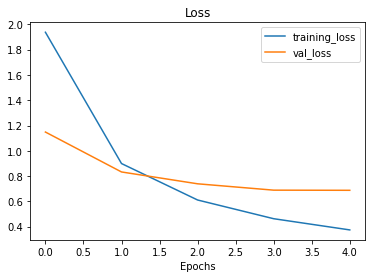

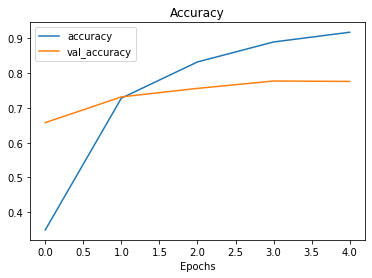

In [18]:
plot_loss_curves (resnet_history)

### Creating a EfficinetNetB0 TensorFlow Hub Feature Extraction model

In [19]:
#  create a EfficinetNetB0 feature exatractor model
efficinetnet_model = create_model (model_url = efficientnet_url ,
                                   num_classes = train_data_10_percent.num_classes)


# Compile our EfficinetNetB0 model
efficinetnet_model.compile (loss = tf.keras.losses.CategoricalCrossentropy(),
                      optimizer = tf.keras.optimizers.Adam(),
                      metrics = ["accuracy"])

# Fit EfficinetNetB0 model to 10% of training data 
efficinetnet_history = efficinetnet_model.fit (train_data_10_percent,
                                   epochs = 5,
                                   steps_per_epoch = len(train_data_10_percent),
                                   validation_data = test_data,
                                   validation_steps = len (test_data) ,
                                   callbacks = [create_tensorboard_callback (dir_name = "tensorflow_hub" ,
                                                                             experiment_name = "EfficinetNetB0"
                                                                             )])

Saving TensorBoard log files to tensorflow_hub/EfficinetNetB0/20240222-095925
Epoch 1/5
24/24 [==============================] - 62s 3s/step - loss: 1.8557 - accuracy: 0.4320 - val_loss: 1.2852 - val_accuracy: 0.7268
Epoch 2/5
24/24 [==============================] - 70s 3s/step - loss: 1.0633 - accuracy: 0.7747 - val_loss: 0.8583 - val_accuracy: 0.8248
Epoch 3/5
24/24 [==============================] - 68s 3s/step - loss: 0.7584 - accuracy: 0.8307 - val_loss: 0.6929 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 69s 3s/step - loss: 0.6108 - accuracy: 0.8747 - val_loss: 0.6060 - val_accuracy: 0.8596
Epoch 5/5
24/24 [==============================] - 68s 3s/step - loss: 0.5168 - accuracy: 0.8893 - val_loss: 0.5523 - val_accuracy: 0.8680


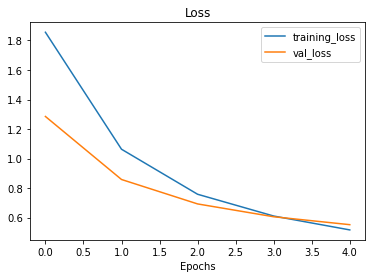

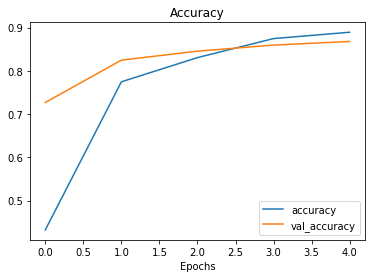

In [20]:
plot_loss_curves (efficinetnet_history)

In [21]:
efficinetnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layers (K (None, 1280)              4049564   
_________________________________________________________________
output_layers (Dense)        (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [22]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layers (K (None, 2048)              23564800  
_________________________________________________________________
output_layers (Dense)        (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different type of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using InageNet model on 1000 Imagent classes, none of your own)
* **"Feature extraction” transfer learning** - use the prelearned patterns of an existing model (e.g. EficientNetB0 trained on InageNet) and adjust the output layer for your own problem (e.g  1000 classes --> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the pre-learned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

In [27]:
# How many layers does our efficientnetb0 feature extractor have?
len (efficinetnet_model.layers[0].weights)

309

## Comparing our models results using TensorBoard

>  Note: When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things
you don't want others to se) do not upload the to TensorBoard.dev.

In [3]:
from keras.callbacks import TensorBoard

In [4]:
!pwd

/media/muneeb/muneeb_harddisk/Thesis/TensorFlow_ Developer_Certificate_Zero_to_Mastery/DL


In [5]:
#  Upload TensorBoard dev records
!tensorboard dev upload --logdir ./media/muneeb/muneeb_harddisk/Thesis/TensorFlow_ Developer_Certificate_Zero_to_Mastery/DL/tensorflow_hub/--name "EfficientNetB0 vs. ResNet50V2" --discription "Comparing two different TF HUB feature extraction model architecture using 10% of the training data" --one_shot

2024-02-22 10:47:40.541345: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-02-22 10:47:40.541363: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: unrecognized arguments: Developer_Certificate_Zero_to_Mastery/DL/tensorflow_hub/--name EfficientNetB0 vs. ResNet50V2 --discription Comparing two different TF HUB feature extraction model architecture using 10% of the training data


In [6]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2024-02-22 11:04:46.571447: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-02-22 11:04:46.571505: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) ^C
Traceback (most recent call

In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id dQBrpdwIRgS2qT0AndvEYg

In [ ]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list